In [1]:
#INITIALIZE SPARK SESSION
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("PodPres").getOrCreate()

assembled_df = spark.read.parquet("final_features_human_labels.parquet")
assembled_df.printSchema()
assembled_df.show()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/12 15:26:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/05/12 15:26:53 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/05/12 15:26:53 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


root
 |-- segment_id: long (nullable = true)
 |-- podcast_name_cleaned: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- label: string (nullable = true)

+----------+--------------------+--------------------+-----+
|segment_id|podcast_name_cleaned|            features|label|
+----------+--------------------+--------------------+-----+
|         0|Bill OReillys No ...|[-4.0,-0.02415416...|  0.8|
|         0|Bill OReillys No ...|[-4.0,-0.02415416...|  0.5|
|         0|Bill OReillys No ...|[-4.0,-0.02415416...|  0.8|
|         0|Bill OReillys No ...|[-4.0,-0.02415416...|    1|
|         0|Bill OReillys No ...|[-4.0,-0.02415416...|  0.7|
|         0|Bill OReillys No ...|[-4.0,-0.02415416...|  0.2|
|         0|Bill OReillys No ...|[-4.0,-0.02415416...|  0.4|
|         0|Bill OReillys No ...|[-4.0,-0.02415416...|  0.5|
|         1|    pod save america|[10.0,-0.01585099...|  0.5|
|         1|    pod save america|[10.0,-0.01585099...|  0.7|
|         1|    pod save america

In [2]:
from pyspark.sql.functions import rand

# Shuffle the DataFrame
shuffled_df = assembled_df.orderBy(rand())

In [3]:
from pyspark.sql.functions import col
from pyspark.sql.types import FloatType
#split data
train_df, test_df = shuffled_df.randomSplit([0.8, 0.2], seed=42)
train_df = train_df.withColumn("label", col("label").cast(FloatType()))
test_df = test_df.withColumn("label", col("label").cast(FloatType()))

In [4]:
# Get the statistical summary for the "label" column
train_df.describe("label").show()

+-------+-------------------+
|summary|              label|
+-------+-------------------+
|  count|                727|
|   mean| 0.4993122421317776|
| stddev|0.32568988952814487|
|    min|                0.0|
|    max|                1.0|
+-------+-------------------+



In [5]:
from pyspark.sql.functions import col, count, lit

# Calculate the total number of rows to compute proportions
total_count = train_df.count()

# Group by the 'label' column and calculate the count of each label
label_distribution = train_df.groupBy("label").count()

# Calculate the percentage of each label
label_distribution = label_distribution.withColumn("percentage", (col("count") / lit(total_count) * 100))

# Display the results
label_distribution.show()

+-----+-----+------------------+
|label|count|        percentage|
+-----+-----+------------------+
|  0.1|  126| 17.33149931224209|
|  0.6|   18|2.4759284731774414|
|  0.9|   85|11.691884456671252|
|  0.5|  127| 17.46905089408528|
|  1.0|   69| 9.491059147180192|
|  0.3|   49| 6.740027510316368|
|  0.4|   28| 3.851444291609354|
|  0.8|   78|10.729023383768913|
|  0.2|   75| 10.31636863823934|
|  0.0|   33|  4.53920220082531|
|  0.7|   39| 5.364511691884457|
+-----+-----+------------------+



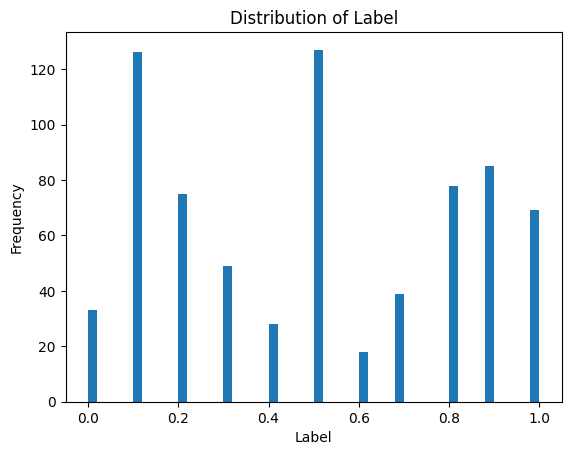

In [6]:
import matplotlib.pyplot as plt

# Retrieve the "label" data
label_data = train_df.select("label").rdd.flatMap(lambda x: x).collect()

# Plot the histogram
plt.hist(label_data, bins=50)  # bins参数根据数据的具体情况调整
plt.title('Distribution of Label')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()

In [7]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol='features', labelCol='label', maxIter=10, regParam=0.01, elasticNetParam=0.5)
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler

# Assuming 'features' is already a vector. If not, use VectorAssembler to create it
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scalerModel = scaler.fit(train_df)
scaled_train_df = scalerModel.transform(train_df)
scaled_test_df = scaler_model.transform(test_df)

# Update the model to use scaled features
lr = LinearRegression(featuresCol='scaledFeatures', labelCol='label', maxIter=10, regParam=0.01, elasticNetParam=0.5)
lr_model = lr.fit(scaled_train_df)

# coefficients& intercept
coefficients = lr_model.coefficients
intercept = lr_model.intercept

print("Coefficients:", coefficients)
print("Intercept:", intercept)


24/05/12 15:27:08 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors
24/05/12 15:27:08 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/05/12 15:27:08 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


Coefficients: [0.0,0.0,0.0,0.0,-7.689080378070578e-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005170946569939649,-0.0003452795871730785,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0027482523271173996,0.0,0.0,0.0,0.0,-0.0065382941690664996,0.00747445902412088,0.0,0.0,-0.016701636294854983,0.0,0.005172397806576669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0001201190179197438,-0.0005479232921946634,0.0,0.0,0.0,0.0,-6.192417611148405e-05,0.0,0.0,0.0,0.0,0.0,-0.005260498615706161,0.0,0.0,0.0,0.006856160646480592,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-8.908057993421692e-05,0.0,-0.00173815605033061,0.0,0.0,-0.0019482584701685823,0.0,0.0,0.0,0.0,0.0,-0.0056077475576067305,0.0,5.3768254767720284e-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014973813649998417,-0.002428886686365196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0049149463697602085,-0.0024468421166749777,0.007631955774358275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0024037968265018554,

In [8]:
from pyspark.ml.evaluation import RegressionEvaluator

# predict test data
predictions = lr_model.transform(scaled_test_df)

# result
predictions.select("prediction", "label").show()

+-------------------+-----+
|         prediction|label|
+-------------------+-----+
| 0.5068905565007438|  0.5|
| 0.5068905565007438|  0.8|
|  0.525925113897235|  0.1|
|  0.525925113897235|  0.8|
| 0.5029314755281276|  0.3|
| 0.5029314755281276|  0.8|
|  0.436224530591255|  0.5|
| 0.5368907711633844|  0.5|
| 0.5303198398247992|  0.6|
| 0.5303198398247992|  0.7|
| 0.4526595416591831|  0.1|
| 0.4526595416591831|  0.1|
| 0.4526595416591831|  0.5|
|  0.495240422259514|  0.1|
|  0.495240422259514|  0.9|
| 0.5027636442248332|  0.7|
|0.47034342330867085|  0.8|
|  0.512553232246481|  0.9|
|0.46328163591005334|  0.4|
|0.46328163591005334|  0.9|
+-------------------+-----+
only showing top 20 rows



In [9]:
from pyspark.ml.evaluation import RegressionEvaluator

# Create an instance of the evaluator
evaluator_rmse = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="rmse")
evaluator_r2 = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="r2")

# 计算 RMSE 和 R-squared
rmse = evaluator_rmse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared: {r2}")

Root Mean Squared Error (RMSE): 0.3128044842945006
R-squared: -0.007541229874268973


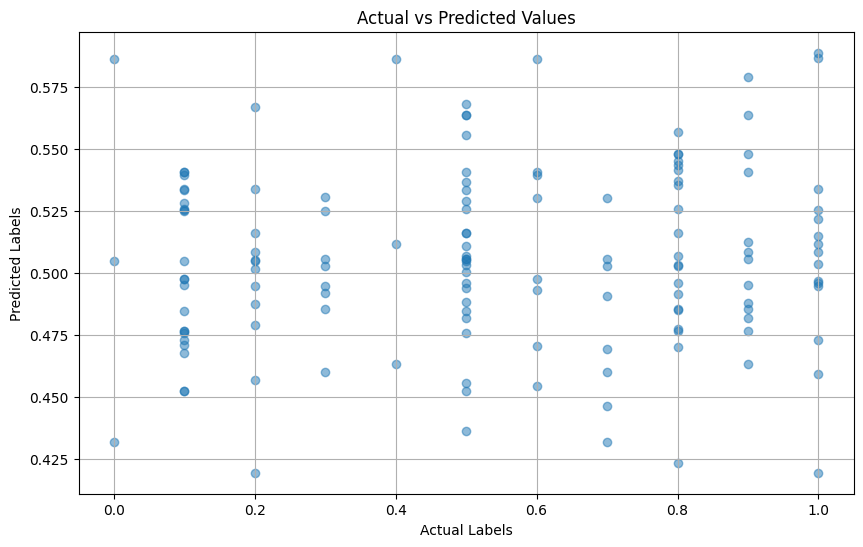

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

prediction_data = predictions.select("label", "prediction").toPandas()

# Plot a scatter plot of actual values versus predicted values
plt.figure(figsize=(10, 6))
plt.scatter(prediction_data['label'], prediction_data['prediction'], alpha=0.5)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Actual vs Predicted Values')
plt.grid(True)
plt.show()

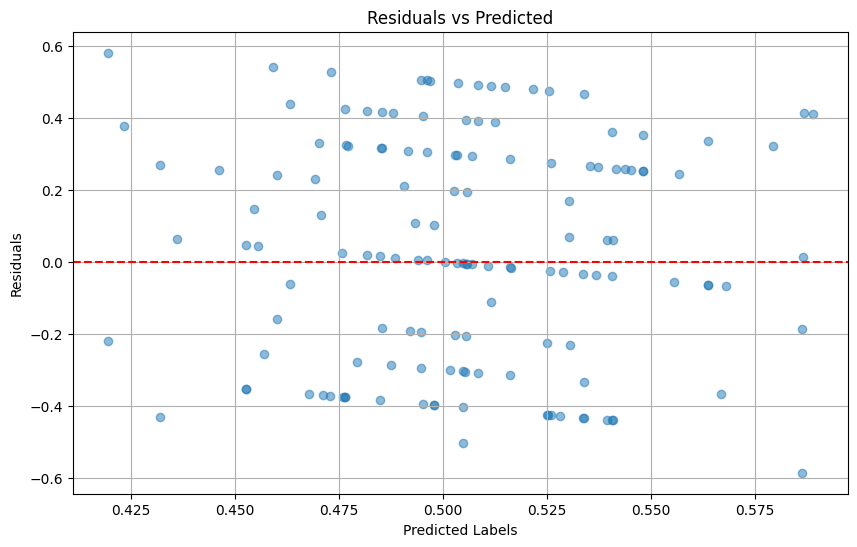

In [13]:
# Calculate residuals
prediction_data['residuals'] = prediction_data['label'] - prediction_data['prediction']

# Plot the residuals
plt.figure(figsize=(10, 6))
plt.scatter(prediction_data['prediction'], prediction_data['residuals'], alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Labels')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.grid(True)
plt.show()

In [11]:
from pyspark.sql.functions import col

# Calculate the winning probabilities for Trump and Biden
predictions_with_probabilities = predictions.withColumn("probability_trump", col("prediction")) \
                                            .withColumn("probability_biden", 1 - col("prediction"))


predictions_with_probabilities.select("probability_trump", "probability_biden").show()


+-------------------+-------------------+
|  probability_trump|  probability_biden|
+-------------------+-------------------+
| 0.5068905565007438|0.49310944349925623|
| 0.5068905565007438|0.49310944349925623|
|  0.525925113897235|0.47407488610276505|
|  0.525925113897235|0.47407488610276505|
| 0.5029314755281276|0.49706852447187244|
| 0.5029314755281276|0.49706852447187244|
|  0.436224530591255|  0.563775469408745|
| 0.5368907711633844|0.46310922883661565|
| 0.5303198398247992|0.46968016017520076|
| 0.5303198398247992|0.46968016017520076|
| 0.4526595416591831| 0.5473404583408169|
| 0.4526595416591831| 0.5473404583408169|
| 0.4526595416591831| 0.5473404583408169|
|  0.495240422259514| 0.5047595777404861|
|  0.495240422259514| 0.5047595777404861|
| 0.5027636442248332| 0.4972363557751668|
|0.47034342330867085| 0.5296565766913292|
|  0.512553232246481|0.48744676775351903|
|0.46328163591005334| 0.5367183640899467|
|0.46328163591005334| 0.5367183640899467|
+-------------------+-------------

In [12]:
from pyspark.sql.functions import avg

# Calculate the average value of the 'prediction' column
trump_win_probability = predictions_with_probabilities.agg(avg("probability_trump")).first()[0]
biden_win_probability = predictions_with_probabilities.agg(avg("probability_biden")).first()[0]

# Output the probability
print(f"Trumo Win Probability: {trump_win_probability:.2f}")
print(f"Biden Win Probability: {biden_win_probability:.2f}")

Trumo Win Probability: 0.51
Biden Win Probability: 0.49
